# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 8
# Ensemble methods

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave


Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold, train_test_split
from sklearn.learning_curve import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_auc_score
import seaborn as sns


%matplotlib inline


/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between a collision that produces Higgs bosons and collisions thats produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle colision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.


## Question 1 (2pt): Single Decision Tree
We start by building a basic model which we will use as our base model for comparison. 

1. Fit a decision tree model to the training set and report the classification accuracy of the model on the test set. Use 5-fold cross-validation to choose the (maximum) depth for the tree. You will use the max_depth you find here throughout the homework. 


In [362]:
# Import train and test set
train = pd.read_csv('Higgs_train.csv')
test = pd.read_csv('Higgs_test.csv')

# Each column name picks up a leading ' ', remove
train = train.rename(columns=lambda x: x.strip())
test = test.rename(columns=lambda x: x.strip())

# Split into x and y
train_x = train.drop(['class'], axis=1)
train_y = train['class']
test_x = test.drop(['class'], axis=1)
test_y = test['class']

x_test_std = (test_x - train_x.mean())/train_x.std()
x_train_std = (train_x - train_x.mean())/train_x.std()

# Set up dec-tree, perform a k-fold cross-validated grid search
max_depths = range(1, 15)
dec_tree = GridSearchCV(DecisionTreeClassifier(),
                        param_grid = dict(max_depth = max_depths),
                        cv = 5,
                        scoring = 'accuracy')

dec_tree.fit(x_train_std, train_y)

# Obtain results and output performance
max_depth = dec_tree.best_params_['max_depth']
print("Decision has best cross-validated score (5 folds) at max_depth =", max_depth)
print("This results in a classification accuracy (on test set) of", dec_tree.score(x_test_std, test_y))

Decision has best cross-validated score (5 folds) at max_depth = 5
This results in a classification accuracy (on test set) of 0.6456


## Question 2 (15pt): Dropout-based Approach
We start with a simple method inspired from the idea of 'dropout' in machine learning, where we fit multiple decision trees on random subsets of predictors, and combine them through a majority vote. The procedure is described below.

- For each predictor in the training sample, set the predictor values to 0 with probability $p$  (i.e. drop the predictor by setting it to 0). Repeat this for $B$ trials to create $B$ separate training sets.


- Fit decision tree models $\hat{h}^1(x), \ldots, \hat{h}^B(x) \in \{0,1\}$ to the $B$ training sets. 

- Combine the decision tree models into a single classifier by taking a majority vote:
$$
\hat{H}_{maj}(x) \,=\, majority\Big(\hat{h}^1(x), \ldots, \hat{h}^B(x)\Big).
$$


We shall refer to the combined classifier as an ** *ensemble classifier* **. Implement the described dropout approach, and answer the following questions:
1. Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?
[hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

In [363]:
def dropout_procedure(p, num_trees, train_x, train_y, test_x):    
    # Input error checking
    if list(train_x.columns) != list(test_x.columns):
        raise ValueError("Different predictors in train and test!")
    
    # Set up necessary variables
    H_hats_train, H_hats_test = [], [] # List of predictions of each dropout model
    dec_tree = DecisionTreeClassifier(max_depth = max_depth)
    full_classifier = train_x.columns
    
    # Now, iterate over each "tree w/dropout" to get predictions
    for tree in range(num_trees):
        # Build training set
        pred_zero = [pred for pred in full_classifier if np.random.random() <= p]
        train_x_dropout = train_x.copy(deep=True)
        train_x_dropout.loc[:, pred_zero] = 0
        
        # Build test set
        test_x_dropout = test_x.copy(deep=True)
        test_x_dropout.loc[:, pred_zero] = 0
        
        # Train tree
        dec_tree.fit(train_x_dropout, train_y)
        
        # Make prediction h_hat and store in H_hats list
        H_hats_train.append(dec_tree.predict(train_x_dropout))
        H_hats_test.append(dec_tree.predict(test_x_dropout))
        
        # Clean up the temporary x sets in loop, because they're large
        del train_x_dropout
        del test_x_dropout
            
    # Turn our num_trees into a majority "vote" for each observation and return
    H_hats_train, H_hats_test = np.array(H_hats_train), np.array(H_hats_test)
    return np.round(H_hats_train.mean(axis=0), 0), np.round(H_hats_test.mean(axis=0), 0)


# Demo/test function
p = 0.5
num_trees = 32
print(dropout_procedure(p, num_trees, x_train_std, train_y, x_test_std))

(array([ 1.,  0.,  1., ...,  0.,  1.,  1.]), array([ 1.,  1.,  0., ...,  0.,  0.,  1.]))


Trees = 2. Train acc = 0.6748.  Test acc = 0.648
Trees = 4. Train acc = 0.691.  Test acc = 0.6584
Trees = 8. Train acc = 0.7102.  Test acc = 0.6672
Trees = 16. Train acc = 0.703.  Test acc = 0.6502
Trees = 32. Train acc = 0.7276.  Test acc = 0.678
Trees = 64. Train acc = 0.7338.  Test acc = 0.6854
Trees = 128. Train acc = 0.729.  Test acc = 0.689
Trees = 256. Train acc = 0.7288.  Test acc = 0.6838


(0.5, 0.8)

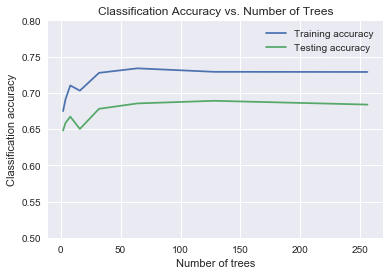

In [364]:
# Question 2.1:

# System variables
p = 0.5
num_trees_list = [2, 4, 8, 16, 32, 64, 128, 256]

# Our output lists
train_accs = []
test_accs = []

# Iterate over number of trees:
for num_trees in num_trees_list:
    train_y_hat, test_y_hat = dropout_procedure(p, num_trees, x_train_std, train_y, x_test_std)
    this_train_acc = accuracy_score(train_y_hat, train_y)
    this_test_acc = accuracy_score(test_y_hat, test_y)
    
    # Save accuracies and output at each step
    train_accs.append(this_train_acc)
    test_accs.append(this_test_acc)
    print("Trees = {}. Train acc = {}.  Test acc = {}".
              format(num_trees, this_train_acc, this_test_acc))

# Plot output
plt.plot(num_trees_list, train_accs, label="Training accuracy")
plt.plot(num_trees_list, test_accs, label="Testing accuracy")
plt.ylim((0,0.75))
plt.legend()
plt.xlabel("Number of trees")
plt.ylabel("Classification accuracy")
plt.title("Classification Accuracy vs. Number of Trees")
plt.ylim(0.5,0.8)

1) Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.

**For a small number of trees, we have a lower variance and higher bias as we increase the number of trees, we added complexity to the model, so we increased variance but lowered bias - there is a limit for adding the number of trees increasing the accuracy. Before achieving ~60 trees threshold, adding new trees increases the accuracy (decreases the variance). Once we reach ~60 trees, adding additional trees does not improve nor worsen our accuracy. This is because as we choose our predictors for each tree randomly in the dropout approach, we de-correlate the trees and thus adding new trees barely increases the variance.**

P = 0.1. Train acc = 0.682.  Test acc = 0.6456
P = 0.3. Train acc = 0.7026.  Test acc = 0.6668
P = 0.5. Train acc = 0.7314.  Test acc = 0.6848
P = 0.7. Train acc = 0.7284.  Test acc = 0.6764
P = 0.9. Train acc = 0.5676.  Test acc = 0.5504


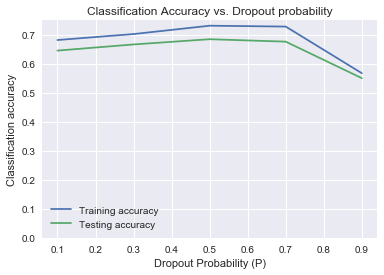

In [107]:
# Question 2.2:

# System variables
ps_list = [0.1, 0.3, 0.5, 0.7, 0.9]
num_trees = 64

# Our output lists
train_accs = []
test_accs = []

# Iterate over number of trees:
for p in ps_list:
    train_y_hat, test_y_hat = dropout_procedure(p, num_trees, x_train_std, train_y, x_test_std)
    this_train_acc = accuracy_score(train_y_hat, train_y)
    this_test_acc = accuracy_score(test_y_hat, test_y)
    
    # Save accuracies and output at each step
    train_accs.append(this_train_acc)
    test_accs.append(this_test_acc)
    print("P = {}. Train acc = {}.  Test acc = {}".
              format(p, this_train_acc, this_test_acc))

# Plot output
plt.plot(ps_list, train_accs, label="Training accuracy")
plt.plot(ps_list, test_accs, label="Testing accuracy")
plt.ylim((0,0.75))
plt.legend()
plt.xlabel("Dropout Probability (P)")
plt.ylabel("Classification accuracy")
plt.title("Classification Accuracy vs. Dropout probability")

**Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.**

For dropout rates of 0.1 to 0.5, the accuracy increases on both the train and test set.<br><br>
For dropout rates of 0.5 to 0.9, the accuracy decreases on both the train and test set (and it decreases especially quickly from p = 0.7-0.9.<br><br>
This is likely happening because a p of 0.5 balances bias and variance.  When p < 0.5, the model will have a lower feature dropoff rate (and therefore have higher complexity).  when P > 0.5, the model will have higher dropoff and lower complexity.<br><br>
So in the model with P<0.5, the variance dominates as each model tends towards being over-complex.  In the model with P>0.5, bias dominates as each model tends towards oversimplicity. <br><br>
Both cases result in a decrease in accuracy, and the peak balance between the two occurs at p~0.5.

.....P = 0.1.  Trees = 2. Mean 5-fold accuracy = 0.637
.....P = 0.1.  Trees = 4. Mean 5-fold accuracy = 0.635
.....P = 0.1.  Trees = 8. Mean 5-fold accuracy = 0.636
.....P = 0.1.  Trees = 16. Mean 5-fold accuracy = 0.634
.....P = 0.1.  Trees = 32. Mean 5-fold accuracy = 0.635
.....P = 0.1.  Trees = 64. Mean 5-fold accuracy = 0.635
.....P = 0.3.  Trees = 2. Mean 5-fold accuracy = 0.631
.....P = 0.3.  Trees = 4. Mean 5-fold accuracy = 0.644
.....P = 0.3.  Trees = 8. Mean 5-fold accuracy = 0.647
.....P = 0.3.  Trees = 16. Mean 5-fold accuracy = 0.647
.....P = 0.3.  Trees = 32. Mean 5-fold accuracy = 0.652
.....P = 0.3.  Trees = 64. Mean 5-fold accuracy = 0.654
.....P = 0.5.  Trees = 2. Mean 5-fold accuracy = 0.621
.....P = 0.5.  Trees = 4. Mean 5-fold accuracy = 0.633
.....P = 0.5.  Trees = 8. Mean 5-fold accuracy = 0.648
.....P = 0.5.  Trees = 16. Mean 5-fold accuracy = 0.662
.....P = 0.5.  Trees = 32. Mean 5-fold accuracy = 0.662
.....P = 0.5.  Trees = 64. Mean 5-fold accuracy = 0.665
.

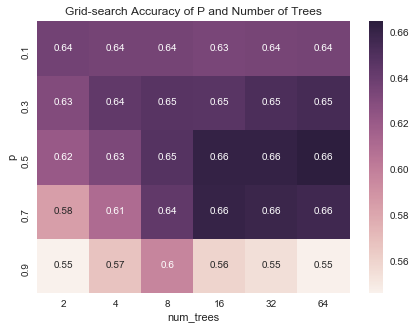

In [365]:
# Question 2.3:
verbose = False

# System variables
ps_list = [0.1, 0.3, 0.5, 0.7, 0.9]
num_trees_list = [2, 4, 8, 16, 32, 64] 
# Note we're now just using up to 64 trees.
# As seen in 2.1, there does not seem to be a big increase in the accuracy for
# >64 trees, but it takes much more computation time.

# Our output lists (only taking validation accuracy now)
#val_table = pd.DataFrame(columns=['p', 'num_trees', 'accuracy'])
val_table = []

folds = KFold(n_splits = 5)

for p in ps_list: # Iterave over value of p
    for num_trees in num_trees_list: # Iterate over number of trees:
        
        fold_acc= [] # Obtain fresh accuracy scores for our 5 folds
        for train_index, val_index in folds.split(train_x): # Perform 5-fold CV
            # Train on training set and get validation y_hat
            train_y_hat, val_y_hat = dropout_procedure(
                p, num_trees, 
                x_train_std.iloc[train_index,:], train_y.iloc[train_index], 
            x_train_std.iloc[val_index,:])
            fold_acc.append(accuracy_score(val_y_hat, train_y[val_index]))
            
            # Some debug outputs/progress meter for mid-fold
            if verbose: # Debug outputs
                print("Train acc = {}.  Val acc = {}".
                      format(accuracy_score(train_y_hat, train_y[train_index]),
                            accuracy_score(val_y_hat, train_y[val_index])))
            else: # Progress meter
                print(".", end="")
            
        # This fold completed, add to final table
        fold_mean = np.array(fold_acc).mean()
        val_table.append({'p':p, 'num_trees':num_trees, 'accuracy':fold_mean})
        print("P = {}.  Trees = {}. Mean 5-fold accuracy = {:.3}".
            format(p, num_trees, fold_mean))

# Computation complete.  Plot output
val_out = pd.DataFrame.from_dict(val_table)
plt.figure(figsize = (7,5))
sns.heatmap(val_out.pivot(index = 'p', columns = 'num_trees', values = 'accuracy'), annot = True)
plt.title("Grid-search Accuracy of P and Number of Trees")

3) How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1? [hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

<br>** The single decision tree from Question 1 achieved a classification accuracy (on test set) of 0.6456.**</br>

** The ensemble with optimal number of trees (64) and dropout rate of 0.5 achieved a classification accuracy (on the test set) of 0.663.**

** Thus, the accuracy of ensemble with the dropout procedure is marginally better.**

## Question 3 (15pt): Random Forests

We now move to a more sophisticated ensemble technique, namely random forest:
1. How does a random forest approach differ from the dropout procedure described in Question 2? 
 
- Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

- Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 
  
- Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?  





1) How does a random forest approach differ from the dropout procedure described in Question 2?

**In a dropout approach, we train the entire tree on a given subset of the predictors (randomly selected) which is the same as in random forest, but we do not do bootstrap aggregation. **


2) Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

In [352]:
tree_count = [2**i for i in range(1,9)]
train_scores = []
test_scores = []
for n_trees in tree_count:
    rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt')
    test_scores.append(metrics.accuracy_score(y_test, rf.fit(x_train_std, y_train).predict(x_test_std)))
    train_scores.append(metrics.accuracy_score(y_train, rf.fit(x_train_std, y_train).predict(x_train_std)))
    

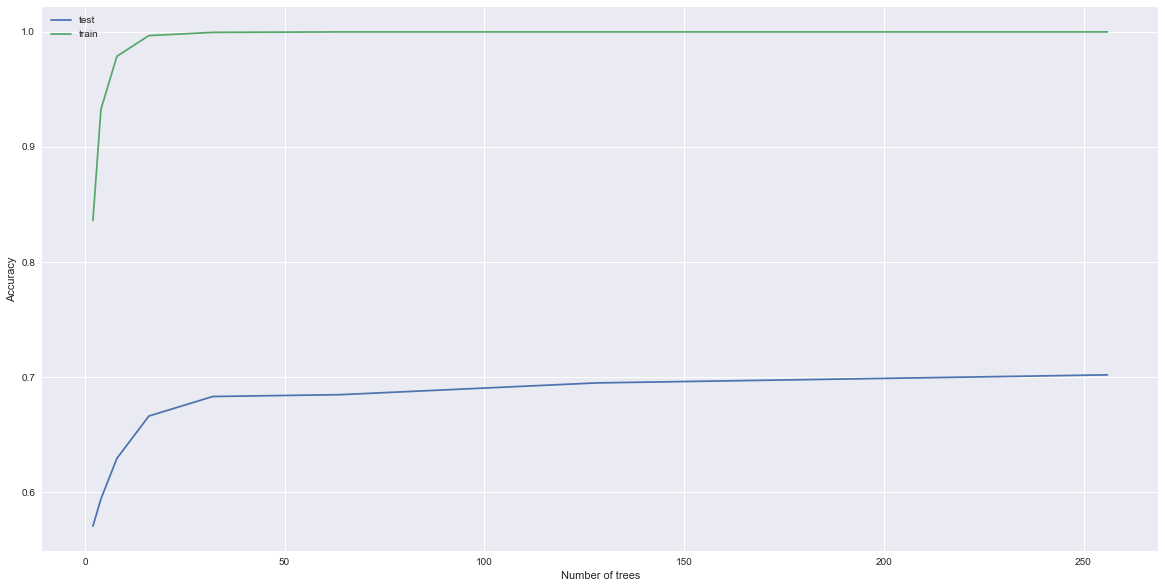

In [353]:
plt.figure(figsize=(20,10))
plt.plot(tree_count, test_scores, label='test')
plt.plot(tree_count, train_scores, label='train')
plt.legend(loc='best')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.show()

3) Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier.

**Larger number of trees does not neccessarily improve the accuracy of the RF, beyond a certain tree number threshold, we achieve a 100% accuracy on the training set. However, given the random feature selection nature of each decision tree in the random forest, we still avoid overfitting and the accuracy on the test set is not decreasing.**

**If the number of the trees in the random forest ensemble becomes VERY large, the trees may become more correlated, increasing the variance and decreasing the robustness. As we increase the number of trees, the bias does not change and remains identical to bias of a single randomized tree.**

4) Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?

The accuracy of a RF with random feature selection among 9 randomly 
selected predictors is 0.6804


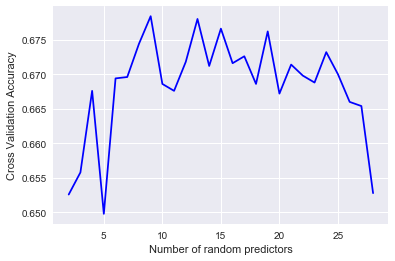

In [361]:
#fixing the number of trees to a reasonable value
n_trees = 30

max_n_predictors = len(x_train_std.columns)

#cross val over number of predictors
folds = KFold(n_splits=5,shuffle=False)
n_rand_features_scores = {}

for n_predictors in range(2,max_n_predictors+1):
    current_train_score =[]
    
    for train_idx, val_idx in folds.split(x_train_std):
        
        rf = RandomForestClassifier(n_estimators=n_trees, max_features=n_predictors)
        rf.fit(x_train_std.iloc[train_idx],y_train.iloc[train_idx])
        
        current_train_score.append(rf.score(x_train_std.iloc[val_idx],y_train.iloc[val_idx]))
        
    n_rand_features_scores[n_predictors] = np.array(current_train_score).mean()

# Now get accuracy with the best number for random subset of predictors on the test set
best_n_features = max(n_rand_features_scores,key=n_rand_features_scores.get)

best_pred_rf = RandomForestClassifier(n_estimators=n_trees, max_features=best_n_features)
best_pred_rf.fit(x_train_std,y_train)
print("The accuracy of a RF with random feature selection among {} randomly \nselected predictors is {}".format(best_n_features,best_pred_rf.score(x_test_std,y_test)))

plt.plot([i for i in n_rand_features_scores.keys()], [v for v in n_rand_features_scores.values()], 'b-')
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Number of random predictors")
plt.show()

In [339]:
# Now fit the best number for subset of random predictors on the test set
best_n_features = max(n_rand_features_scores,key=n_rand_features_scores.get)

best_pred_rf = RandomForestClassifier(n_estimators=n_trees, max_features=best_n_features)
best_pred_rf.fit(x_train_std,y_train)
print("The accuracy of a RF with random feature selection among {} randomly \nselected predictors is {}".format(best_n_features,best_pred_rf.score(x_test_std,y_test)))

The accuracy of a RF with random feature selection among 5 randomly 
selected predictors is 0.677


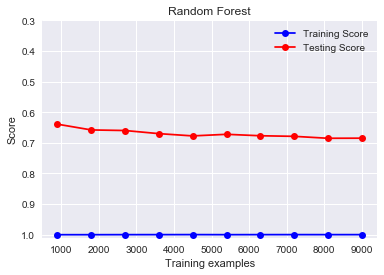

In [340]:
complete_df = pd.concat([train_df,test_df],axis=0)

X = np.array(complete_df.iloc[:, complete_df.columns != 'class'])
y = np.array(complete_df['class'])

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=n_trees, max_features=best_n_features), X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(.1, 1., 10), verbose=0)
 
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
 
plt.figure()
plt.title("Random Forest")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim((0.3, 1.01))
plt.gca().invert_yaxis()
 
# Plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test score")
plt.legend(['Training Score', 'Testing Score'], loc = 1)

**This looks like our model high variance (overfitting on our data - as our error on the test set is much higher than on the training set), meaning that our model does not generalize well on the test data (reference to standard section 9) but low bias.**

How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?

**Dropout approach test performance: 0.66, RF test performance 0.677.**

## Question 4 (15pt): Boosting

We next compare the random forest model with the approach of boosting:


1. Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).
- How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.
- How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.
- Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 



In [114]:
accuracies_train = []
accuracies_test = []
trees = [2**x for x in range(9)]

for md in [1,2,10,None]:
    depth_accuracies_train = []
    depth_accuracies_test = []
    for n in trees:
        ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=md),n_estimators=n, learning_rate=.05)
        depth_accuracies_train.append(metrics.accuracy_score(y_train, ada.fit(x_train_std,y_train).predict(x_train_std)))
        depth_accuracies_test.append(metrics.accuracy_score(y_test, ada.fit(x_train_std,y_train).predict(x_test_std)))
    accuracies_train.append(depth_accuracies_train)
    accuracies_test.append(depth_accuracies_test)

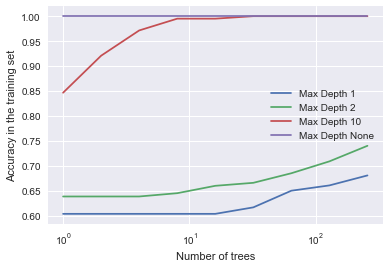

In [115]:
for i, md in enumerate([1,2,10,None]):
    plt.semilogx(trees, accuracies_train[i], label='Max Depth {}'.format(md))
plt.legend(loc='best')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy in the training set')
plt.show()

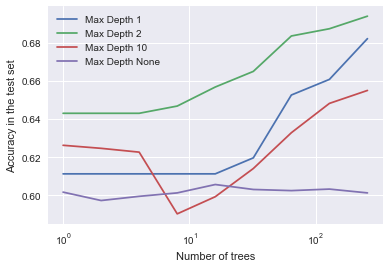

In [331]:
for i, md in enumerate([1,2,10,None]):
    plt.semilogx(trees, accuracies_test[i], label='Max Depth {}'.format(md))
plt.legend(loc='best')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy in the test set')
plt.show()

2) How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.

**Increasing number of trees increases the accuracy of the model in both training and test sets with ADA boost, but can lead to overfitting when we have too many trees or when the max depth of the base classifier is high (see the question below).**

**When we have simple trees and the learning rate is not too high to "overshoot" the stationary point, adding more trees to the ensemble increases the test set accuracy to a certain threshold - after that we can get overfitting from too many trees, which is marginalized by setting the learning rate very small for the additional unnecessary trees.**

**In random forest, increasing the number of trees did not have an effect on the model bias (recall the bias of a single random tree is the same as that of the ensemble) but possibly increased variance if we start having correlations among trees in the ensemble.**

3) How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.

**If the maximum depth of the simple decision tree as the base learner is set too high we achieve overfitting. In our case max_depth = 10 starts to overfit  on the training set at ~9 trees in the ensemble and the improvement in accuracy on the test set plateaus. Also, boosting of an ensemble of decision trees with unrestricted depth overfits on the training set from the beginning and the accuracy on the test set does not improve with an increased number of trees in the ensemble. This make intuitive sense as we increase the specificity of our model with increased tree depth thus increasing the general error.**

**We would not recommend to use unrestricted depth for ADA boosting as boosting decreases bias and increases expressivity for simple trees and does not work on complex trees. **

4) Apply 5-fold cross-validation to choose the optimal number of trees  B
  for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4?

In [117]:
from sklearn.grid_search import GridSearchCV

param_grid = {"base_estimator__max_depth" : [1,2,10,None],
              "n_estimators": [2**x for x in range(9)]
             }

DTC = DecisionTreeClassifier(random_state = 11)

ABC = AdaBoostClassifier(base_estimator = DTC,learning_rate=0.05)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')

grid_search_ABC.fit(x_train_std,y_train)

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=11, splitter='best'),
          learning_rate=0.05, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'base_estimator__max_depth': [1, 2, 10, None], 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [118]:
grid_search_ABC.score(x_test_std,y_test)

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.76007266105082516

In [119]:
grid_search_ABC.best_params_

{'base_estimator__max_depth': 2, 'n_estimators': 128}

In [120]:
print("The accuracy of a RF with random feature selection among {} randomly \nselected predictors is {}".format(best_n_features,best_pred_rf.score(x_test_std,y_test)))
print("\n")
print("The accuracy with the ADA boost with depth {} of the base learner (Decision tree) \nand {} trees in the ensemble is {}".format(grid_search_ABC.best_params_['base_estimator__max_depth'],grid_search_ABC.best_params_['n_estimators'],
                                grid_search_ABC.score(x_test_std,y_test)))

The accuracy of a RF with random feature selection among 9 randomly 
selected predictors is 0.6798


The accuracy with the ADA boost with depth 2 of the base learner (Decision tree) 
and 128 trees in the ensemble is 0.7600726610508252


/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


**The ADA classifier with optimal number of trees and optimal depth of the base learner achieves a better accuracy than RF in the case of this data set.**

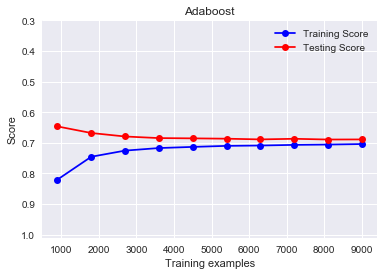

In [121]:
complete_df = pd.concat([train_df,test_df],axis=0)

X = np.array(complete_df.iloc[:, complete_df.columns != 'class'])
y = np.array(complete_df['class'])

train_sizes, train_scores, test_scores = learning_curve(
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=grid_search_ABC.best_params_['base_estimator__max_depth']),n_estimators=grid_search_ABC.best_params_['n_estimators'], learning_rate=.05), X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(.1, 1., 10), verbose=0)
 
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Adaboost")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim((0.3, 1.01))
plt.gca().invert_yaxis()
 
# Plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test score")
plt.legend(['Training Score', 'Testing Score'], loc = 1)

**As we can see from the plot above, we achieve lower variance with the ADA boost classifier compared to Random Forest. However, we have higher bias compared to the Random Forest (and bigger error on the training data).**

## Question 5 (3pt): Meta-classifier

We have so far explored techniques that grow a collection of trees either by creating multiple copies of the original training set, or through a sequential procedure, and then combines these trees into a single classifier. Consider an alternate scenario where you are provided with a pre-trained collection of trees, say from different participants of a data science competition for Higgs boson discovery. What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

A collection of 100 decision tree classifiers is provided in the file `models.npy` and can be loaded into an array by executing:

`models = np.load('models.npy')`

You can make predictions using the $i^\text{th}$ model on an array of predictors `x` by executing:

`model[i].predict(x)`  &nbsp;&nbsp;&nbsp;
or &nbsp;&nbsp;&nbsp;
`model[i].predict_proba(x)`

and score the model on predictors `x` and labels `y` by using:

`model[i].score(x, y)`.

1. Implement a strategy to combine the provided decision tree classifiers, and compare the test perfomance of your approach with the majority vote classifier. Explain your strategy/algorithm.



In [367]:
# Question 5

# Load models
models = np.load('models.npy', encoding='latin1')

#Majority vote
predictions = models[0].predict(x_test_std)

#gather predictions from each model
for model in models[1:]:
    predictions = np.vstack((predictions,model.predict(x_test_std)))
#average predictions and convert to binary
total_pred = np.mean(predictions,axis=0)
bool_pred = [np.bool(i) for i in np.round(total_pred,decimals=0)]

print("Accuracy of the ensemble of {} models using the majority vote is {}" .format(len(models),metrics.accuracy_score(y_test,bool_pred)))

Accuracy of the ensemble of 100 models using the majority vote is 0.5044


In [366]:
#we will try several classification models without regularization/CV
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

meta_learners = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(learning_rate=0.05)]

#only grabbing 20 models to decrease time complexity for now
for meta in meta_learners:
    sclf = StackingClassifier(classifiers=[model for model in models[:20]], use_probas=True, 
                          meta_classifier=meta)
    sclf.fit(x_train_std,y_train)
    
    #predict without the regularization of the meta-learner
    print("Accuracy of the stack model (meta-learner: {}) without regularization: Cross-val training score: {}.  Test score:{}."
          .format(str(meta.__class__).split('.')[-1].strip("'>"),
                  cross_val_score(sclf,x_train_std, y_train, cv=5).mean(),
                  metrics.accuracy_score(y_test,sclf.predict(x_test_std))))

Accuracy of the stack model (meta-learner: LogisticRegression) without regularization: Cross-val training score: 0.5946106806106807.  Test score:0.6054.
Accuracy of the stack model (meta-learner: DecisionTreeClassifier) without regularization: Cross-val training score: 0.5910110746110745.  Test score:0.6064.
Accuracy of the stack model (meta-learner: RandomForestClassifier) without regularization: Cross-val training score: 0.5934132784132784.  Test score:0.6044.
Accuracy of the stack model (meta-learner: AdaBoostClassifier) without regularization: Cross-val training score: 0.5914110750110749.  Test score:0.6022.


In [381]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

#Regularized Logistic Regression as the meta-learner

lr = LogisticRegression()
sclf_lr = StackingClassifier(classifiers=[model for model in models], use_probas=True, 
                          meta_classifier=lr)

params = {'meta-logisticregression__C': np.logspace(-2,3,5)}

grid = GridSearchCV(estimator=sclf_lr, param_grid=params, cv=3,refit=True)
grid.fit(x_train_std, y_train)
print("Accuracy of the stack model with CV regularized logistic regression meta-learner: Cross-val training score: {}.  Test score: {}"
      .format(grid.best_score_,
          metrics.accuracy_score(y_test,grid.predict(x_test_std))))

Accuracy of the stack model with CV regularized logistic regression meta-learner: Cross-val training score: 0.5952.  Test score: 0.6054


In [384]:
#Decision Tree classifier as meta-learner

dt = DecisionTreeClassifier()
sclf_dt = StackingClassifier(classifiers=[model for model in models], use_probas=True, 
                          meta_classifier=dt)

sclf_dt.fit(x_train_std,y_train)

depths = [i for i in range(3,20)]

#select the best depth for the decision tree meta-classifier

params = {'meta-decisiontreeclassifier__max_depth': depths}
grid = GridSearchCV(estimator=sclf_dt, param_grid=params, cv=3,refit=True)
grid.fit(x_train_std, y_train)

print("Accuracy of the stack model with regularized Decision Tree Classif. meta-learner {}, Test accuracy:{}"
      .format(grid.best_score_,
          metrics.accuracy_score(y_test,grid.predict(x_test_std))))

Accuracy of the stack model with regularized Decision Tree Classif. meta-learner 0.5972, Test accuracy:0.6066


In [376]:
max_n_predictors = len(x_train_std.columns)
n_trees = 20

#cross val over number of predictors
folds = KFold(n_splits=5,shuffle=False)
n_rand_features_scores = {}

for n_predictors in range(2,max_n_predictors+1):
    current_train_score =[]
    
    for train_idx, val_idx in folds.split(x_train_std):
        
        rf = RandomForestClassifier(n_estimators=n_trees, max_features=n_predictors)

        sclf_rf = StackingClassifier(classifiers=[model for model in models], use_probas=True, 
                          meta_classifier=rf)
        
        sclf.fit(x_train_std.iloc[train_idx],y_train.iloc[train_idx])
        
        current_train_score.append(sclf.score(x_train_std.iloc[val_idx],y_train.iloc[val_idx]))
        
    n_rand_features_scores[n_predictors] = np.array(current_train_score).mean()
    print(".",end="")
    
# Now get accuracy with the best number for random subset of predictors on the test set
best_n_features = max(n_rand_features_scores,key=n_rand_features_scores.get)

#select the random forest with the best number of features

best_pred_rf = RandomForestClassifier(n_estimators=n_trees, max_features=best_n_features)

sclf_rf_best = StackingClassifier(classifiers=[model for model in models], use_probas=True, 
                          meta_classifier=best_pred_rf)

sclf_rf_best.fit(x_train_std,y_train)

print("Accuracy of the stack model with regularized Random Forest Classif. meta-learner CV {}".format(metrics.accuracy_score(y_test,sclf_rf_best.predict(x_test_std))))

...........................Accuracy of the stack model with regularized Random Forest Classif. meta-learner CV 0.6042


In [379]:
#ADA boost as the meta-learner
DTC = DecisionTreeClassifier(random_state = 11)

ABC = AdaBoostClassifier(base_estimator = DTC,learning_rate=0.05)

sclf_ada = StackingClassifier(classifiers=[model for model in models], use_probas=True, 
                          meta_classifier=ABC)


# run grid search
param_grid = {"meta-adaboostclassifier__base_estimator__max_depth" : [2,3],
              "meta-adaboostclassifier__n_estimators": [2**x for x in range(4)]
             }

grid_sclf_ada = GridSearchCV(sclf_ada, param_grid=param_grid, cv=3,refit=True)

grid_sclf_ada.fit(x_train_std,y_train)

print("Accuracy of the stack model with ADA Boost meta-learner CV: CV training accuracy: {}. Test accuracy:{}"
      .format(grid_sclf_ada.best_score_,
          metrics.accuracy_score(y_test,grid_sclf_ada.predict(x_test_std))))



Accuracy of the stack model with ADA Boost meta-learner CV: CV training accuracy: 0.5966.  Test accuracy:0.6036


Our strategy was to use cross-validation to choose from a number of ensemble models.  

The metaclassifier models we selected (as shown in the code above) are logistic regression, adaboost, randomforest, and a single decision tree.

For each metaclassifier, we use cross-validation to fit on the training data, and compare each model performance.  We see that all models are viable (ie, close to each other in terms of accuracy), so we further tune each meteaclassifier model's parameters using cross-validation on the training set.

Overall, the highest CV training set performance was found to be ADA Boot, with a CV training accuracy of 0.5966.  The ultimate test set accuracy of this classifier was found to be 0.6036, which is a significant improvement versus the basic voting classifier.

--- 

---

## APCOMP209a - Homework Question
​
We've worked with imputation methods on missing data in Homework 6.  We've worked with Decision Trees in HW7 and here.  Now let's see what happens if we try to work with Decision Trees and Missing Data at the same time! We'll be working with a dataset from the UCI Machine Learning Repository that uses a variety of wine chemical predictors to classify wines grown in the same region in Italy.  Each line represents 13 (mostly chemical) predictors of the response variable wine class, including things like alcohol content, hue , and phenols.  Unfortunately some of the predictor values were lost in measurement. Please load `wine_quality_missing.csv`. 
​
*Note*: As in HW6 be careful of reading/treating column names and row names in this data set.
​
​
1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the sklearn DecisionTreeClassifier and RandomForestClassifier.   Use cross-validation to find the optimal tree depth for each method.  Report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.
2. Restart with a fresh copy of the data and impute the missing data via mean imputation.  Split the data 75-25 and again fit DecisionTreeClassifier and RandomForestClassifier using cross-validation to find the optimal tree depth.  Report the optimal tree depth, overall classification rate and confusion matrix on the test set for each method.  


In [351]:
# Question 1

# Data input
# Import train and test set
wine = pd.read_csv('wine_quality_missing.csv').dropna()

# Split intro train and test
np.random.seed(42)
msk = np.random.rand(len(wine)) < 0.75
wine_train = wine[msk]
wine_test = wine[~msk]

# Split train and test into x and y
wine_train_x = wine_train.drop(['Class'], axis = 1)
wine_train_y = wine_train['Class']
wine_test_x = wine_test.drop(['Class'], axis = 1)
wine_test_y = wine_test['Class']

max_depths = range(1, 15)

# Set up dec-tree, perform a k-fold cross-validated grid search
dt_cv = GridSearchCV(DecisionTreeClassifier(),
                        param_grid = dict(max_depth = max_depths),
                        cv = 5,
                        scoring = 'accuracy')
dt_cv.fit(wine_train_x, wine_train_y)

# Set up random forest, perform a k-fold cross-validated grid search
rf_cv = GridSearchCV(RandomForestClassifier(),
                        param_grid = dict(max_depth = max_depths),
                        cv = 5,
                        scoring = 'accuracy')
rf_cv.fit(wine_train_x, wine_train_y)

# Output results
print("Question 1 - Solutions")
print("Decision tree:")
print("--------------")
print("Best performance at max_depth =", dt_cv.best_params_['max_depth'])
print("5-Fold CV training accuracy =", dt_cv.best_score_)
print("Test set accuracy =", dt_cv.score(wine_test_x, wine_test_y))
print("Confusion matrix:")
print(confusion_matrix(wine_test_y, dt_cv.predict(wine_test_x)))
print("\n")
print("Random Forest:")
print("--------------")
print("Best performance at max_depth =", rf_cv.best_params_['max_depth'])
print("5-Fold CV training accuracy =", rf_cv.best_score_)
print("Test set accuracy =", rf_cv.score(wine_test_x, wine_test_y))
print("Confusion matrix:")
print(confusion_matrix(wine_test_y, rf_cv.predict(wine_test_x)))

Question 1 - Solutions
Decision tree:
--------------
Best performance at max_depth = 3
5-Fold CV training accuracy = 0.857142857143
Test set accuracy = 0.75
Confusion matrix:
[[3 1 0]
 [0 1 1]
 [0 0 2]]


Random Forest:
--------------
Best performance at max_depth = 6
5-Fold CV training accuracy = 0.942857142857
Test set accuracy = 1.0
Confusion matrix:
[[4 0 0]
 [0 2 0]
 [0 0 2]]


In [350]:
# Question 2

# Data input
# Import train and test set
wine = pd.read_csv('wine_quality_missing.csv')

# Perform mean imputation
imputer = Imputer(strategy='mean')
for col in wine.columns:
    imputed = imputer.fit_transform(wine[col].values.reshape(-1,1))
    wine[col] = imputed

# Split intro train and test
np.random.seed(9001) # Random seed 9001, I CAN'T QUIT YOU
msk = np.random.rand(len(wine)) < 0.75
wine_train = wine[msk]
wine_test = wine[~msk]

# Split train and test into x and y
wine_train_x = wine_train.drop(['Class'], axis = 1)
wine_train_y = wine_train['Class']
wine_test_x = wine_test.drop(['Class'], axis = 1)
wine_test_y = wine_test['Class']

max_depths = range(1, 15)

# Set up dec-tree, perform a k-fold cross-validated grid search
dt_cv = GridSearchCV(DecisionTreeClassifier(),
                        param_grid = dict(max_depth = max_depths),
                        cv = 5,
                        scoring = 'accuracy')
dt_cv.fit(wine_train_x, wine_train_y)

# Set up random forest, perform a k-fold cross-validated grid search
rf_cv = GridSearchCV(RandomForestClassifier(),
                        param_grid = dict(max_depth = max_depths),
                        cv = 5,
                        scoring = 'accuracy')
rf_cv.fit(wine_train_x, wine_train_y)

# Output results
print("Question 2 - solutions")
print("Decision tree:")
print("--------------")
print("Best performance at max_depth =", dt_cv.best_params_['max_depth'])
print("5-Fold CV training accuracy =", dt_cv.best_score_)
print("Test set accuracy =", dt_cv.score(wine_test_x, wine_test_y))
print("Confusion matrix:")
print(confusion_matrix(wine_test_y, dt_cv.predict(wine_test_x)))
print("\n")
print("Random Forest:")
print("--------------")
print("Best performance at max_depth =", rf_cv.best_params_['max_depth'])
print("5-Fold CV training accuracy =", rf_cv.best_score_)
print("Test set accuracy =", rf_cv.score(wine_test_x, wine_test_y))
print("Confusion matrix:")
print(confusion_matrix(wine_test_y, rf_cv.predict(wine_test_x)))

Question 2 - solutions
Decision tree:
--------------
Best performance at max_depth = 5
5-Fold CV training accuracy = 0.869918699187
Test set accuracy = 0.836363636364
Confusion matrix:
[[15  5  0]
 [ 1 16  1]
 [ 1  1 15]]


Random Forest:
--------------
Best performance at max_depth = 12
5-Fold CV training accuracy = 0.951219512195
Test set accuracy = 0.963636363636
Confusion matrix:
[[18  2  0]
 [ 0 18  0]
 [ 0  0 17]]
